<a href="https://colab.research.google.com/github/blantj/car_image_recognition/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import os
import shutil
import numpy as np
!pip install split_folders
import splitfolders
from keras.preprocessing.image import ImageDataGenerator
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.callbacks import EarlyStopping
from keras import models, layers
from keras import optimizers, losses
from keras.applications import NASNetLarge
from tensorflow.keras.models import Model

# Obtain Data

Unzip car image recognition dataset files

In [2]:
!tar --gunzip --extract --verbose --file=/content/drive/MyDrive/Car_image_recognition/car_devkit.tgz
!tar --gunzip --extract --verbose --file=/content/drive/MyDrive/Car_image_recognition/cars_test.tgz
!tar --gunzip --extract --verbose --file=/content/drive/MyDrive/Car_image_recognition/cars_train.tgz

Streaming output truncated to the last 5000 lines.
cars_train/03145.jpg
cars_train/03146.jpg
cars_train/03147.jpg
cars_train/03148.jpg
cars_train/03149.jpg
cars_train/03150.jpg
cars_train/03151.jpg
cars_train/03152.jpg
cars_train/03153.jpg
cars_train/03154.jpg
cars_train/03155.jpg
cars_train/03156.jpg
cars_train/03157.jpg
cars_train/03158.jpg
cars_train/03159.jpg
cars_train/03160.jpg
cars_train/03161.jpg
cars_train/03162.jpg
cars_train/03163.jpg
cars_train/03164.jpg
cars_train/03165.jpg
cars_train/03166.jpg
cars_train/03167.jpg
cars_train/03168.jpg
cars_train/03169.jpg
cars_train/03170.jpg
cars_train/03171.jpg
cars_train/03172.jpg
cars_train/03173.jpg
cars_train/03174.jpg
cars_train/03175.jpg
cars_train/03176.jpg
cars_train/03177.jpg
cars_train/03178.jpg
cars_train/03179.jpg
cars_train/03180.jpg
cars_train/03181.jpg
cars_train/03182.jpg
cars_train/03183.jpg
cars_train/03184.jpg
cars_train/03185.jpg
cars_train/03186.jpg
cars_train/03187.jpg
cars_train/03188.jpg
cars_train/03189.jpg
cars

# Scrub Data

Split image files into seperate folders for each class


In [3]:
os.mkdir(f'/content/cars_train/pre-split/')
for num in range(1,197):
  os.mkdir(f'/content/cars_train/pre-split/{num}')

annotations = scipy.io.loadmat('/content/devkit/cars_train_annos.mat')['annotations'][0]
for index, annotation in enumerate(annotations):
  im_class = annotation[4][0][0]
  im_name = str(index+1).zfill(5) + '.jpg'
  shutil.move(f'/content/cars_train/{im_name}', f'/content/cars_train/pre-split/{im_class}/{im_name}')


Split dataset into train, test and validation folders

In [4]:
input_folder = '/content/cars_train/pre-split'
output_folder = '/content/cars_train/post-split'

splitfolders.ratio(input_folder, output=output_folder, seed=37, ratio=(.64, .2, .16))

Copying files: 8144 files [00:22, 358.14 files/s]


Count number of images in training, test and val sets

In [5]:
train_folder = '/content/cars_train/post-split/train'
test_folder = '/content/cars_train/post-split/test'
val_folder = '/content/cars_train/post-split/val'

train_imgs = []
test_imgs = []
val_imgs = []


for img_class in range(1,197):
  train_imgs.extend([file for file in os.listdir(train_folder+'/'+str(img_class)) if file.endswith('.jpg')])
  test_imgs.extend([file for file in os.listdir(test_folder+'/'+str(img_class)) if file.endswith('.jpg')])
  val_imgs.extend([file for file in os.listdir(val_folder+'/'+str(img_class)) if file.endswith('.jpg')]) 

train_batch_size = len(train_imgs)
test_batch_size = len(test_imgs)
val_batch_size = len(val_imgs)

print('Train batch size:', train_batch_size)
print('Test batch size:', test_batch_size)
print('Val batch size:', val_batch_size)

Train batch size: 5108
Test batch size: 1490
Val batch size: 1546


Generate image data from .jpg files

In [6]:
train_generator = ImageDataGenerator().flow_from_directory(
                        train_folder, target_size=(331, 331), batch_size = train_batch_size)

test_generator = ImageDataGenerator().flow_from_directory(
                        test_folder, target_size=(331, 331), batch_size = test_batch_size) 

val_generator = ImageDataGenerator().flow_from_directory(
                        val_folder, target_size=(331, 331), batch_size = val_batch_size) 

Found 5108 images belonging to 196 classes.
Found 1490 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.


Split image data into image and label variables

In [7]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

# Explore Data

Calculate shape of train, test and val image sets

In [8]:
print('Train images shape: ', train_images.shape)
print('Test images shape: ', test_images.shape)
print('Val images shape: ', val_images.shape)

Train images shape:  (5108, 331, 331, 3)
Test images shape:  (1490, 331, 331, 3)
Val images shape:  (1546, 331, 331, 3)


Calculate shape of train, test and val labels sets

In [9]:
print('Train labels shape: ', train_labels.shape)
print('Test labels shape: ', test_labels.shape)
print('Val labels shape: ', val_labels.shape)

Train labels shape:  (5108, 196)
Test labels shape:  (1490, 196)
Val labels shape:  (1546, 196)


Calculate class balance

Class
119    68
79     49
161    48
167    48
56     47
       ..
175    31
64     30
158    29
99     28
136    24
Name: index, Length: 196, dtype: int64
Average Class Size 41.55102040816327


[]

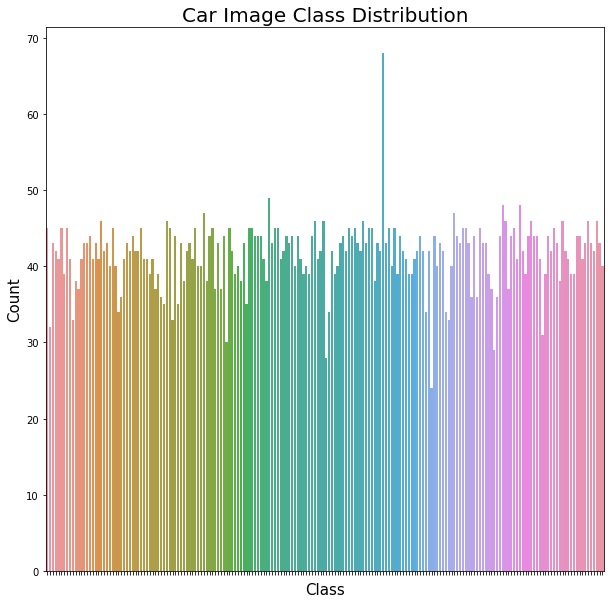

In [10]:
im_classes = []
for image in scipy.io.loadmat('/content/devkit/cars_train_annos.mat')['annotations'][0]:
  im_classes.append(image[4][0][0])
class_df = pd.DataFrame(data=im_classes, columns=['Class'])

print(class_df.reset_index().groupby('Class').count()['index'].sort_values(ascending=False))
print('Average Class Size', (train_batch_size+test_batch_size+val_batch_size)/196)

fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(data=class_df, x='Class', ax=ax)
ax.set_title('Car Image Class Distribution', fontsize=20)
ax.set_xlabel('Class', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_xticklabels(labels=[])

# Model Data

Build neural network in Keras

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(512, (3, 3), activation='relu',
                        input_shape=(331 ,331,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SpatialDropout2D(0.1))

model.add(layers.Conv2D(512, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SpatialDropout2D(0.1))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(196, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Train Keras Neural Network

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(train_images,
                    train_labels,
                    epochs=20,
                    batch_size=331,
                    validation_data=(test_images, test_labels),
                    callbacks=[es])

In [ ]:
pre_model = NASNetLarge(
    input_shape=train_images.shape[1:],
    include_top=False,
    weights="imagenet")
pre_model.summary()

In [ ]:
output = pre_model.output
output = layers.GlobalAveragePooling2D()(output)
output = layers.Dense(128, activation='relu')(output) 
output = layers.Dropout(0.1)(output) 
output = layers.Dense(196, activation='sigmoid')(output)

model=Model(inputs=pre_model.input,outputs=output)

In [ ]:
model.compile(optimizer='Adam',loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(train_images,
                    train_labels,
                    epochs=20,
                    batch_size=32,
                    validation_data=(test_images, test_labels),
                    callbacks=[es])